# Data Visualisering

Data_visual.ipynb er en interaktiv og visuell presentasjon av analysene fra data_analysis.ipynb. Hensikten er å formidle innsiktene på en informativ og engasjerende måte, rettet mot et bredere publikum.

Vi starter med fokus på nedbør, med en visualisering som viser fordelingen av ulike nedbørstyper (i prosent) for hvert år i perioden 2014–2024. Deretter følger en oversikt over tørkeperiodene i samme periode.

Deretter visualiseres vinddata gjennom percentiler, samt en årlig oversikt over høyeste, laveste og gjennomsnittlig vindhastighet.
Siste delen blir en heatmap som viser trender i temperatur og en histogram over årlig forekomster av "ekstremvær".

In [ ]:
#imports
import pandas as pd
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

original_file = "blindern_data_cleaning.csv"
data_path = os.path.join(os.getcwd(),"..", "data")
original_path = os.path.join(data_path, original_file)  
df = pd.read_csv(original_path, delimiter=";")
df["Tid"] = pd.to_datetime(df["Tid"])

from modelling.data_analysis import DataAnalysis


import json

bins_path = os.path.join(os.getcwd(), "..", "data", "bins.json")
with open(bins_path, "r", encoding="utf-8") as f:
    bin_defs = json.load(f)






### Fordeling av nedbørstype (årlig)
Kakediagrammet viser fordelingen av nedbørstyper som forekomst i et år for alle år fra 2014 til 2024. Det er mulig å velge hvilket år man vil se på ved å velge på menyen på venstre hjørnet. Det er derfor også mulig å se på forskjelller i fordelingen fra år til år, samt økning/minsking av et eller flere nedbørstype. 

In [ ]:



import ipywidgets as widgets
from IPython.display import display
import plotly.express as px


# Load Nedbør bins
nedbør_bins = bin_defs["Nedbør"]

def kategoriser_nedbør(verdi):
    for kategori in nedbør_bins:
        navn, nedre, øvre = kategori  # unpack the list
        if nedre <= verdi <= øvre:
            return navn
    return "Ukjent"


df["Tid"] = pd.to_datetime(df["Tid"])
df["Year"] = df["Tid"].dt.year
df["NedbørKategori"] = df["Nedbør"].apply(kategoriser_nedbør)



#makes the pie chart
def vis_pie(year):
    


    data = df[df["Year"] == year]
    counts = data["NedbørKategori"].value_counts().reset_index()
    counts.columns = ["Kategori", "Antall"]

    fig = px.pie(
        counts,
        values="Antall",
        names="Kategori",
        title=f"Nedbørskategorier – {year}",
        color_discrete_sequence=px.colors.sequential.Aggrnyl,
        
    )
    fig.update_traces(textposition='outside', textinfo='percent+label', sort=False)
    fig.show()

#makes the menu
år_valg = widgets.Dropdown(options=sorted(df["Year"].unique()), description="År:")
widgets.interact(vis_pie, year=år_valg)

      



interactive(children=(Dropdown(description='År:', options=(np.int32(2014), np.int32(2015), np.int32(2016), np.…

<function __main__.vis_pie(year)>

### Tørkeperioder
Grafen gir oversikt over alle tørkeperiode(dager uten nedbør) som varte over 12 kontinuerlig dager. 

In [141]:
import plotly.express as px


# calculation of the dry days
def drydays(df,grense):
    count = 0
    dry_periods = [] 

    for i in range(len(df)-1):
        if df["Nedbør"][i] <= 0:
            count += 1
        else:
            if count >= grense:
                end_date = pd.to_datetime(df["Tid"][i-1]).date()
                start_date = end_date - pd.Timedelta(days=count-1)
                dry_periods.append({
                    "Start": start_date,
                    "End": end_date,
                    "Duration": count
                })
            count = 0

    return pd.DataFrame(dry_periods)




# Generate our dry days DataFrame
dry_periods_df = drydays(df, grense=12)  # Get dry periods with a minimum of 12 days

# Create a Plotly Gantt-like chart to visualize the dry periods
def plot_dry_periods(dry_periods_df):
    fig = px.timeline(
        dry_periods_df,
        x_start="Start",
        x_end="End",
        y="Duration",
        
        labels={"Duration": "Tørkeperioder (dager)", "Start": "Start Date", "End": "End Date"},
        color="Duration",  # Color by duration
        color_continuous_scale="Bluered",
        hover_data=["Start", "End", "Duration"]
    )

    fig.update_layout(
            xaxis_title="Dato",
            yaxis_title="Tørkeperioder(dager)",
            showlegend=False
        )
    fig.show()

# Call the plot function
plot_dry_periods(dry_periods_df)


# Vind
### Vind gjennonm percentiler
Denne koden visualiserer fordelingen av middelvind i form av en percentilkurve. Ved å sortere vindhastighetene og plassere dem langs en skala fra 0 til 100 prosent, får vi et tydelig bilde av hvordan vindverdiene fordeler seg. Grafen gjør det enkelt å identifisere hvor store deler av datagrunnlaget som ligger under bestemte vindnivåer – for eksempel kan man se hvilken vindstyrke som representerer 90. percentil.

In [ ]:

import seaborn as sns
#Get wind data and sorts it
wind_serie=df["Middelvind"]
wind_serie=wind_serie.sort_values().values
percentiles=np.linspace(0,100,len(wind_serie))
#Create and plot the figure
fig = go.Figure()
plot_title = "Vind i percentiler"
fig.add_trace(go.Scatter(x=percentiles, y=wind_serie, mode='lines', name='Percentile',
                        line=dict(dash='solid', width=2)))
fig.update_layout(title_text = plot_title, xaxis_title='Percentile', yaxis_title='Vind m/s',
                legend=dict(x=0.7,  
                            y=0.9), 
                xaxis_range=[0, 105],
                showlegend=False
)
fig.show()



### Linechart 
Denne grafen viser maksimal, minimal og gjennomsnittlig vindstyrke per år i perioden. Den gir et raskt overblikk over variasjonen i vindforhold fra år til år, og kan brukes til å identifisere år med spesielt kraftig eller svak vind.

In [139]:
import plotly.graph_objects as go

# Calculate statistics
df["Year"] = df["Tid"].dt.year
max_wind = df.groupby('Year')['Middelvind'].max().reset_index()
min_wind = df.groupby('Year')['Middelvind'].min().reset_index()
mean_wind = df.groupby('Year')['Middelvind'].mean().reset_index()

# Create figure
fig = go.Figure(data=[
    go.Bar(name='Maksimal Vind', x=max_wind['Year'], y=max_wind['Middelvind']),
    go.Bar(name='Minimal Vind', x=min_wind['Year'], y=min_wind['Middelvind']),
    go.Bar(name='Gjennomsnittlig Vind', x=mean_wind['Year'], y=mean_wind['Middelvind']),
])

# Update layout
fig.update_layout(
    barmode='group',
    title='Vindhastighet over årene',
    xaxis_title='År',
    yaxis_title='Vindhastighet(m/s)'
)

fig.show()

### Heatmap
 Visualiseringen viser gjennomsnittlig maksimumstemperatur for hver måned og hvert år. Den gir et visuelt overblikk over temperaturtrender og sesongvariasjoner gjennom perioden 2014–2024. Varme farger indikerer høyere temperaturer, mens kjøligere farger viser lavere verdier – nyttig for å identifisere varme somre eller milde vintre.

Text(79.75, 0.5, 'Månde')

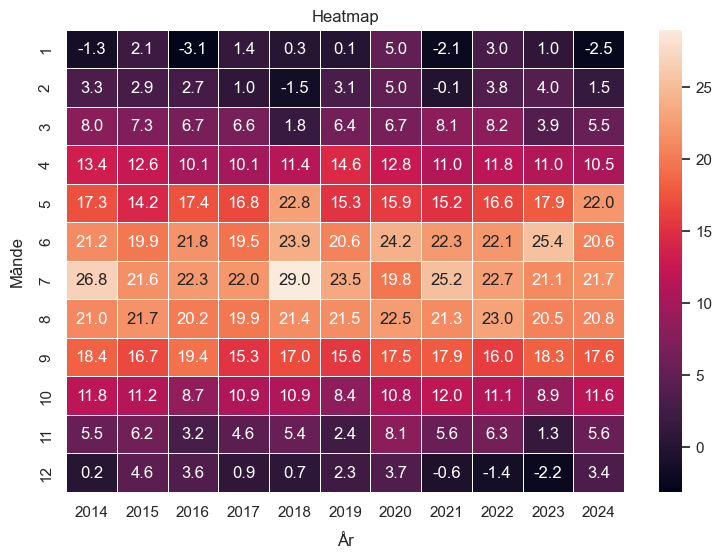

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Create pivot table - months vs years with temperature values
temp_pivot = df.pivot_table(
    index=df["Tid"].dt.month,
    columns=df["Tid"].dt.year,
    values="Makstemp",
    aggfunc='mean'  
)

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(temp_pivot, annot=True, fmt=".1f", linewidths=.5, ax=ax)
ax.set_title("Heatmap")
ax.set_xlabel("År", labelpad=10)  # Set directly on the axis
ax.set_ylabel("Månde", labelpad=10) # Month on x-axis



### Ekstremvær
Denne grafen viser årlige forekomster av ekstremvær, fordelt på ulike værtyper som høy temperatur, lave temperaturer, nedbør, snø og sterke vindkast. Dette kan være nyttig for å identifisere klimatisk utvikling eller perioder med unormalt vær.

In [ ]:
import plotly.express as px
#Use the class dataAnalysis to calculate the severity cases
da = DataAnalysis(df, 'Makstemp', ['Snø', 'Nedbør'], {"Middelvind": 20.8,"Nedbør": 20.0}, bin_defs)
ekstrem_vær = da.years_severity().reset_index().rename(columns={'index': 'Tid'})


#Create plot
fig = px.bar(ekstrem_vær, x="Tid", y=["Makstemp", "Mintemp", "Snø", "Nedbør", "Høye vindkast"], title="Tilfeller av ekstreme vær")
fig.update_yaxes(range=[0, 220])

fig.update_xaxes(tickmode='linear', dtick=1)
fig.show()




